This is Hand Written Text Recognition Project. We will be using **IAM data set**.

Link to dataset: [https://fki.tic.heia-fr.ch/databases/iam-handwriting-database]

## **Data Collection**

1.Download the IAM Words dataset ZIP file.

2.Extract the ZIP file.

3.Create necessary directories (data and data/Words).

4.Extract the contents of the tar archive (words.tgz) into the data/Words directory.

5.Move the words.txt file to the data directory.

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

#drive_folder = '/content/drive/My Drive/Colab Notebooks/HandWritten document recognition'

#!wget -q https://git.io/J0fjL -O "{drive_folder}/IAM_Words.zip"
#!unzip -qq "{drive_folder}/IAM_Words.zip" -d "{drive_folder}"
#!mkdir -p "{drive_folder}/data/Words"
#!tar -xf "{drive_folder}/IAM_Words/words.tgz" -C "{drive_folder}/data/Words"
#!mv "{drive_folder}/IAM_Words/words.txt" "{drive_folder}/data"

In [1]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import Levenshtein as lev

import matplotlib.pyplot as plt
import os
import tensorflow as tf
import editdistance

np.random.seed(42)
tf.random.set_seed(42)

In [3]:
words_file_path = "./words.txt"

 **Getting Words from words.txt**

In [5]:
with open(words_file_path, 'r') as file:
    words = file.readlines()

words_list = []

for line in words:
  if line[0]=="#":
    continue
  if line.split(" ")[1] != "err":  # we do not need to deal with errored entries.
    words_list.append(line)

print(len(words_list))
print(words_list[:5])

np.random.shuffle(words_list)


96456
['a01-000u-00-00 ok 154 408 768 27 51 AT A\n', 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE\n', 'a01-000u-00-02 ok 154 796 764 70 50 TO to\n', 'a01-000u-00-03 ok 154 919 757 166 78 VB stop\n', 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.\n']


In [7]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total data samples: {len(words_list)}")
print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")


Total data samples: 96456
Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


# **Data Input Pipeline**
Our data images are not organized.

We will build our data input pipeline by first preparing the image paths.

In [10]:
base_image_path = "./words"

def get_image_paths_and_labels(samples):
  paths = []
  corrected_samples = []
  for(i,file_line) in enumerate(samples):
    line_split = file_line.strip()
    line_split = line_split.split(" ")
    #each file_line is as "a01-000u-00-03 ok 154 919 757 166 78 VB stop"
    # part1/part1-part2/part1-part2-part3.png

    image_name = line_split[0]
    partI = image_name.split("-")[0]
    partII = image_name.split("-")[1]
    img_path = os.path.join(
        base_image_path, partI , partI + "-" + partII, image_name + ".png"
    )


    if os.path.getsize(img_path):
      paths.append(img_path)
      corrected_samples.append(file_line.split("\n")[0])

  return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)




In [12]:
print(train_img_paths[0:10])
print(train_labels[0:10])

['./words\\e04\\e04-030\\e04-030-04-08.png', './words\\k02\\k02-102\\k02-102-05-03.png', './words\\a01\\a01-082u\\a01-082u-01-04.png', './words\\m01\\m01-000\\m01-000-07-00.png', './words\\g01\\g01-031\\g01-031-07-06.png', './words\\f07\\f07-081b\\f07-081b-01-06.png', './words\\n03\\n03-082\\n03-082-04-03.png', './words\\g06\\g06-018c\\g06-018c-04-05.png', './words\\g06\\g06-011j\\g06-011j-06-06.png', './words\\f04\\f04-024\\f04-024-01-06.png']
['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during', 'm01-000-07-00 ok 196 339 1998 75 107 INO of', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty', 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy', 'n03-082-04-03 ok 165 992 1414 118 135 NN boy', 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The', 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and', 'f04-024-01-06 ok 183 1104 981 60 70 IN in']


# **Feature Extraction**
Now we will take the actual label word from sample_lables.

In [15]:
# finding the maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
  label = label.split(" ")[-1].strip()
  for char in label:
    characters.add(char)

  max_len = max(max_len, len(label))
  train_labels_cleaned.append(label)

print("Maximum Length:",max_len)
print("Vocab size:",len(characters))

#checking

train_labels_cleaned[:10]


Maximum Length: 21
Vocab size: 78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in']

**Now cleaning the validation and the test labels as well.**

In [18]:
def clean_labels(labels):
  cleaned_labels = []
  for label in labels:
    label = label.split(" ")[-1].strip()
    cleaned_labels.append(label)

  return cleaned_labels

validation_labels_cleaned= clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

# **Designing a Character vocabulary.**

The label of the data are character which cannot be directly fit to data instead we need to convert this character to integer. So we will be converting the character label to integer using **StringLookup** by tensorflow

In [21]:
print(characters)
print(len(characters))

{'y', 'x', 'u', 'A', 'E', 'V', '?', 'r', 's', 't', '/', '.', 'C', 'q', 'J', 'B', '9', 'K', 'c', 'Z', '7', 'S', '5', 'l', ';', 'w', 'F', 'n', '1', '!', '6', 'Y', '&', 'H', 'b', ':', 'i', 'G', 'P', 'I', "'", '(', 'a', '3', 'R', '8', 'j', 'M', 'd', 'X', 'D', 'T', 'Q', ')', '*', 'f', 'm', 'v', '0', '2', 'e', 'h', 'g', '#', 'k', '-', 'U', ',', 'N', 'W', 'O', 'p', '4', 'L', '+', 'o', '"', 'z'}
78


In [23]:
AUTOTUNE = tf.data.AUTOTUNE
#TensorFlow will automatically decide the optimal values for characters.

#mapping character to integer
char_to_num = StringLookup(vocabulary = list(characters), mask_token=None)

#mapping integers back to original characters.
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token=None, invert = True)

In [24]:
char_to_num.get_vocabulary()

['[UNK]',
 'y',
 'x',
 'u',
 'A',
 'E',
 'V',
 '?',
 'r',
 's',
 't',
 '/',
 '.',
 'C',
 'q',
 'J',
 'B',
 '9',
 'K',
 'c',
 'Z',
 '7',
 'S',
 '5',
 'l',
 ';',
 'w',
 'F',
 'n',
 '1',
 '!',
 '6',
 'Y',
 '&',
 'H',
 'b',
 ':',
 'i',
 'G',
 'P',
 'I',
 "'",
 '(',
 'a',
 '3',
 'R',
 '8',
 'j',
 'M',
 'd',
 'X',
 'D',
 'T',
 'Q',
 ')',
 '*',
 'f',
 'm',
 'v',
 '0',
 '2',
 'e',
 'h',
 'g',
 '#',
 'k',
 '-',
 'U',
 ',',
 'N',
 'W',
 'O',
 'p',
 '4',
 'L',
 '+',
 'o',
 '"',
 'z']

In [27]:
print(char_to_num(tf.constant(["A"])))
#here A got value 76
# the values nott in the characters  list gets value 0

tf.Tensor([4], shape=(1,), dtype=int64)


# **Image Preprocessing**

### **Resizing image using Padding**


Instead of using square images, many OCR models use rectangular images. You'll see why when we look at some examples from the dataset.Resizing square images without keeping their proportions doesn't distort them much, but this isn't true for rectangular images. However, we need to resize images to the same size for mini-batching. So, we must resize them while:

1. Keeping their aspect ratio the same.
2. Ensuring the image content remains unaffected.

In [32]:
def distortion_free_resize(image, img_size):
  w,h = img_size
  image = tf.image.resize(image, size=(h,w),preserve_aspect_ratio=True)  # size paraeter takes height first and then width
  #The resulting image might not be exactly (h,w) pixels but will fit within these dimensions without any distortion.
  # if any pixel left we will use padding

  #checking the padding height and width
  pad_height = h-tf.shape(image)[0]
  pad_width = w-tf.shape(image)[1]

  #Only necessary if you want to do some amount of padding on both sides.
  if pad_height % 2 !=0:
    height=pad_height//2
    pad_height_top = height +1
    pad_height_bottom = height
  else:
    pad_height_top = pad_height_bottom = pad_height // 2

  if pad_width %2 != 0:
    width = pad_width //2
    pad_width_left = width +1
    pad_width_right = width
  else:
    pad_width_left = pad_width_right = pad_width //2

  image = tf.pad(
      image,
      paddings = [
          [pad_height_top, pad_height_bottom],
          [pad_width_left, pad_width_right],
          [0,0],
      ],

  )
  image = tf.transpose(image, perm=[1,0,2])
  image = tf.image.flip_left_right(image)
  # because tf.resize uses (h,w) way
  return image



# **Putting all together**

In [35]:
batch_size = 32
padding_token = 99
image_width = 128
image_height = 32

def preprocessing_image(image_path, img_size=(image_width, image_height)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image,channels=1) # decode the png_encoded images into tensor , channel 1 for gray scale
  image = distortion_free_resize(image,img_size)
  image = tf.cast(image, tf.float32)/255.0  # data type conversion in tensor
  return image

def vectorize_label(label):
  label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
  length = tf.shape(label)[0]
  pad_amount = max_len-length
  label = tf.pad(label, paddings=[[0,pad_amount]], constant_values = padding_token)
  return label

def process_images_labels(image_path, label):
  image = preprocessing_image(image_path)
  label = vectorize_label(label)
  return {"image":image, "label":label}

def prepare_dataset(image_paths, labels):
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(process_images_labels, num_parallel_calls=AUTOTUNE)
  return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)



**Preparing tf.data.Dataset objects**

In [38]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


### **Visualizing a few Samples**

In [41]:
print(train_ds)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None, None), dtype=tf.int64, name=None)}>


In [43]:
train_ds_iter = iter(train_ds)
batch = next(train_ds_iter)
image_tensor = batch['image']
print("Image tensor details:")
print(f"Shape: {image_tensor.shape}")
print(f"Dtype: {image_tensor.dtype}")
print(f"Example data: {image_tensor.numpy()[0][20]}")  # Print the first image in the batch

label_tensor = batch['label']
print("Label tensor details:")
print(f"Shape: {label_tensor.shape}")
print(f"Dtype: {label_tensor.dtype}")
print(f"Example data: {label_tensor.numpy()[0]}")  # Print the first label in the batch

Image tensor details:
Shape: (32, 128, 32, 1)
Dtype: <dtype: 'float32'>
Example data: [[0.7879308 ]
 [0.41669166]
 [0.33433872]
 [0.5890069 ]
 [0.9208927 ]
 [0.97726715]
 [0.9816583 ]
 [0.9833934 ]
 [0.9833934 ]
 [0.9810781 ]
 [0.97783613]
 [0.97730905]
 [0.9812506 ]
 [0.9661871 ]
 [0.9751751 ]
 [0.9833934 ]
 [0.9839542 ]
 [0.9843137 ]
 [0.9832958 ]
 [0.9818653 ]
 [0.98383915]
 [0.9843137 ]
 [0.98346525]
 [0.98346967]
 [0.97938985]
 [0.9790454 ]
 [0.98290753]
 [0.9843137 ]
 [0.9838823 ]
 [0.98247296]
 [0.9837097 ]
 [0.9843137 ]]
Label tensor details:
Shape: (32, 21)
Dtype: <dtype: 'int64'>
Example data: [ 9  3  8 61 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99 99]


# **Model**

We will be using **CTC(Connectionist Temporal Classification)**  loss as an endpoint layer.CTC is a neural network output layer designed to solve sequence-to-sequence problems where the alignment between input and output sequences is unknown.

**CNNs** (for spatial feature extraction) and **RNNs **(for sequential modeling).

In [47]:
class CTCLayer(keras.layers.Layer):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.loss_fn = keras.backend.ctc_batch_cost

  def call(self,y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len,1), dtype="int64")
    loss = self.loss_fn(y_true, y_pred, input_length, label_length)
    self.add_loss(loss)

    return y_pred

def build_model():
  # Inputs to the model. These are used when the input and output have different structures.
  input_img = keras.Input(shape=(image_width, image_height,1), name = "image")
  labels = keras.layers.Input(name="label", shape=(None,))

  # first conv block.
  x = keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
  x = keras.layers.MaxPooling2D((2,2), name="pool1")(x)

  #Second conv block.
  x = keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer="he_normal", padding="same",name="Conv2")(x)
  x = keras.layers.MaxPooling2D((2,2), name = "pool2")(x)
    
  # Here we have used two max pool with pool size and strides 2.
  # Hence, downsampled feature maps are 4x smaller.
  # The number of filter in the last layer is 64 .
  # Reshape accordingly before passing the output to the RNN part of the model.

  #If the CNN output is of shape (batch_size, new_width, new_height, num_channels), the reshaping converts it to (batch_size, new_width, new_height * num_channels).
  #This is necessary to convert the output of the CNN into a format suitable for the subsequent Dense layer and RNN.
  #primary purpose of Dropout is to prevent overfitting and generalize during the training of the neural network.
  new_shape = ((image_width // 4), (image_height // 4)* 64)
  x = keras.layers.Reshape(target_shape = new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation= "relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  #RNNs
  x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout = 0.25))(x)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = True, dropout = 0.25))(x)
    
  # +2 is to account for the two special tokens introduced by the CTC loss.
  # The recommendation is from https://git.io/J0eXP.
  x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation = "softmax", name="dense2")(x)

  #Add CTC layer for calculating CTC loss at each step.
  output = CTCLayer(name="ctc_loss")(labels, x)

  #Define the model.
  model = keras.models.Model(
      inputs = [input_img, labels], outputs = output, name="handwriting_recognizer")
  #optimizer
  opt = keras.optimizers.Adam()
  #compile the model and return
  model.compile(optimizer = opt)
  return model


#Get model
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

# **Edit Distance as Evaluation Metrix**
Edit distance is the most widely used matric for evaluating OCR models. It is also known as Levenshtein distance, is a metric for evaluating the similarity between two sequences by counting the minimum number of operations required to transform one sequence into the other.




In [49]:
# we first segregate the validation images and their labels for convenience.
with tf.device('/GPU:0'):
  validation_images = []
  validation_labels = []

  for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])


In [52]:
# Now, we create a callback to monitor the edit distances.

def calculate_edit_distance(labels, predictions):
  #converting the labels into a sparse tensors.
  saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

  input_len = np.ones(predictions.shape[0])*predictions.shape[1]
  predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy = True)[0][0][:,:max_len]
  sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded),dtype=tf.int64)

  # compute individual edit distance and average them out.
  edit_distances = tf.edit_distance(
      sparse_predictions, saprse_labels, normalize=False
  )
  return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
  def __init__(self, pred_model):
    super().__init__()
    self.prediction_model = pred_model

  def on_epoch_end(self, epoch, logs=None):
    edit_distance = []

    for i in range(len(validation_images)):
      lables = validation_labels[i]
      predictions = self.prediction_model.predict(validation_images[i])
      edit_distance.append(calculate_edit_distance(labels, predictions).numpy())
    print(
        f"Mean edit distance for epoch {epoch+1}: {np.mean(edit_distance):.4f}"
    )

# **Character Error Rate as Evaluation Metrix**

In [55]:
def calculate_character_error_rate(labels, predictions):
    # Cast predictions to float32 to ensure compatibility with CTCGreedyDecoder
    predictions = tf.cast(predictions, dtype=tf.float32)
    
    # Convert labels to sparse tensor format
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Prepare the input length for CTC decoding
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]

    # Perform CTC decoding
    predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0]

    # Limit the decoded sequence length (assuming max_len is defined somewhere in your code)
    predictions_decoded = predictions_decoded.numpy()[:, :max_len]
    
    # Convert decoded predictions to sparse tensor format
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    # Compute the edit distance between predictions and labels
    edit_distances = tf.edit_distance(sparse_predictions, sparse_labels, normalize=False)

    # Calculate the total number of characters (non-zero values in labels)
    total_characters = tf.reduce_sum(tf.cast(tf.not_equal(labels, 0), dtype=tf.int32))

    # Return the character error rate (total edit distance / total characters)
    return tf.reduce_sum(edit_distances) / tf.cast(total_characters, dtype=tf.float32)




def calculate_word_error_rate(reference, hypothesis):
    return lev.distance(reference.split(), hypothesis.split()) / len(reference.split())


In [57]:
class CharacterErrorRateCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model
        self.cer_per_epoch = []  # To store CER per 5 epochs
        self.wer_per_epoch = []  # To store WER per 5 epochs

    def on_epoch_end(self, epoch, logs=None):
        # Check if current epoch is a multiple of 5
        character_error_rates = []
        word_error_rates = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            cer = calculate_character_error_rate(labels, predictions).numpy()
            character_error_rates.append(cer)

            labels_flat = labels.numpy().flatten() if isinstance(labels, tf.Tensor) else labels.flatten()
            labels_str = ''.join([chr(int(l)) for l in labels_flat if int(l) != 0])
            predictions_flat = np.argmax(predictions, axis=-1).flatten()
            predictions_str = ''.join([chr(int(p)) for p in predictions_flat if int(p) != 0])

            wer = calculate_word_error_rate(labels_str, predictions_str)
            word_error_rates.append(wer)

        # Store CER and WER for this epoch
        self.cer_per_epoch.append(np.mean(character_error_rates))
        self.wer_per_epoch.append(np.mean(word_error_rates))

        print(
            f"Epoch {epoch + 1}: Mean CER = {np.mean(character_error_rates):.4f}, Mean WER = {np.mean(word_error_rates):.4f}"
        )


# **Training the Model**

In [60]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs available: ", gpus)

GPUs available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [62]:
# Continue with model training
with tf.device('/GPU:0'):
    # Your model code here

    epochs = 50
    
    model = build_model()
    input_layer = model.inputs[0]
    output_layer = model.get_layer(name="dense2").output
    prediction_model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    CER_callback = CharacterErrorRateCallback(prediction_model)
    
    # Train the model
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=epochs,
        callbacks=[CER_callback]
    )


Epoch 1/50
1/1 [==============================] - 1s 1s/step
Epoch 1: Mean CER = 0.9651, Mean WER = 1.0013
2713/2713 [==============================] - 529s 184ms/step - loss: 12.6531 - val_loss: 10.6452
Epoch 2/50
1/1 [==============================] - 0s 32ms/step
Epoch 2: Mean CER = 0.9461, Mean WER = 1.0098
2713/2713 [==============================] - 152s 56ms/step - loss: 9.6398 - val_loss: 8.3159
Epoch 3/50
1/1 [==============================] - 0s 31ms/step
Epoch 3: Mean CER = 0.9131, Mean WER = 1.0158
2713/2713 [==============================] - 149s 55ms/step - loss: 7.5665 - val_loss: 6.1598
Epoch 4/50
1/1 [==============================] - 0s 28ms/step
Epoch 4: Mean CER = 0.8758, Mean WER = 1.0341
2713/2713 [==============================] - 151s 56ms/step - loss: 5.8465 - val_loss: 4.5037
Epoch 5/50
1/1 [==============================] - 0s 31ms/step
Epoch 5: Mean CER = 0.8580, Mean WER = 1.0512
2713/2713 [==============================] - 140s 52ms/step - loss: 4.6818 - v

KeyboardInterrupt: 

# **CER and WER plot**

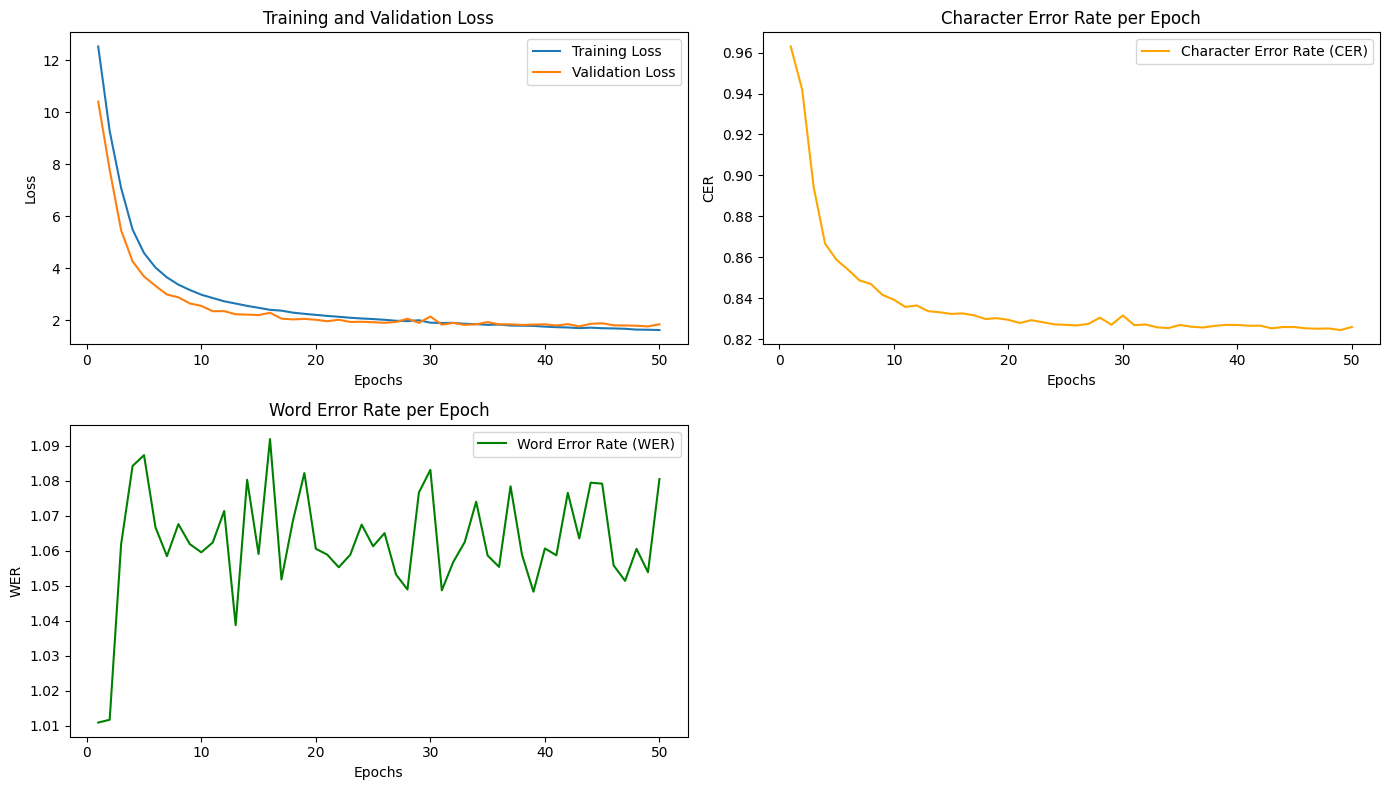

In [66]:
# Plot Training and Validation Loss
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(14, 8))

# Training and Validation Loss
plt.subplot(2, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Character Error Rate (CER)
plt.subplot(2, 2, 2)
plt.plot(epochs_range, CER_callback.cer_per_epoch, label='Character Error Rate (CER)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.title('Character Error Rate per Epoch')
plt.legend()

# Word Error Rate (WER)
plt.subplot(2, 2, 3)
plt.plot(epochs_range, CER_callback.wer_per_epoch, label='Word Error Rate (WER)', color='green')
plt.xlabel('Epochs')
plt.ylabel('WER')
plt.title('Word Error Rate per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

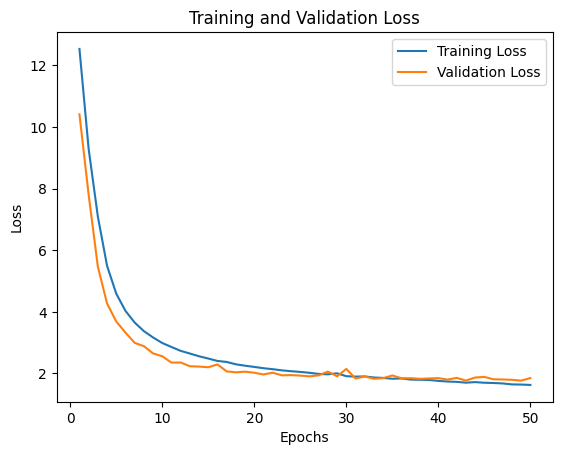

In [78]:
import matplotlib.pyplot as plt

# Plotting the graph
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Save the plot as an image file (e.g., PNG, JPG)
plt.savefig('training_validation_loss.png')  # You can change the file name and format (e.g., 'plot.jpg')

# Optional: Show the plot
plt.show()


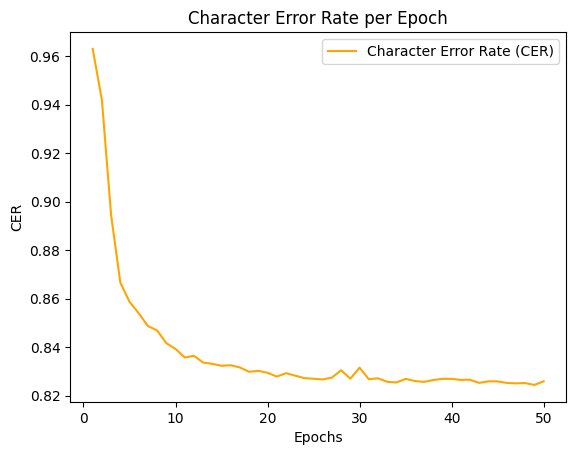

In [80]:
plt.figure()

# Character Error Rate (CER)
plt.plot(epochs_range, CER_callback.cer_per_epoch, label='Character Error Rate (CER)', color='orange')
plt.xlabel('Epochs')
plt.ylabel('CER')
plt.title('Character Error Rate per Epoch')
plt.legend()

# Save the CER plot
plt.savefig('character_error_rate_per_epoch.png')

# Show the plot (optional)
plt.show()


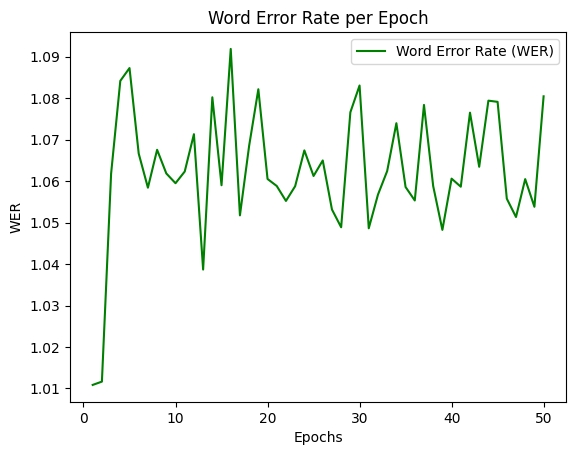

In [82]:
plt.figure()

# Word Error Rate (WER)
plt.plot(epochs_range, CER_callback.wer_per_epoch, label='Word Error Rate (WER)', color='green')
plt.xlabel('Epochs')
plt.ylabel('WER')
plt.title('Word Error Rate per Epoch')
plt.legend()

# Save the WER plot
plt.savefig('word_error_rate_per_epoch.png')

# Show the plot (optional)
plt.show()


In [68]:
prediction_model.save('new_model_V50.h5')

In [70]:
prediction_model.save('new_model_V50.keras')


In [93]:
from tensorflow import keras
loaded_model = keras.models.load_model('model_V5.h5')

OSError: No file or directory found at model_V5.h5

In [92]:
prediction_model.save('model_V149.keras')
prediction_model.save('model_V149.h5')

In [72]:
loaded_model = keras.models.load_model('new_model_V50.keras')

1/1 [==============================] - 19s 19s/step


NameError: name 'decode_batch_prediction' is not defined

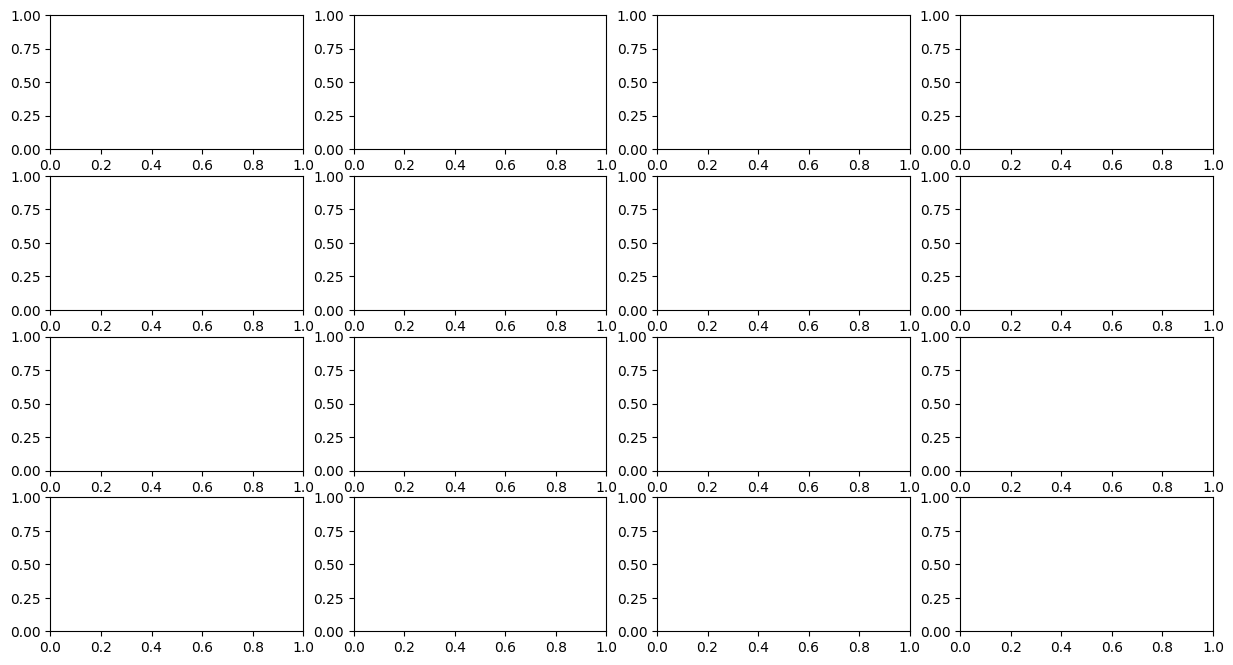

In [74]:



for batch in test_ds.take(8):
  batch_images = batch["image"]
  _, ax = plt.subplots(4,4,figsize=(15,8))

  preds = loaded_model.predict(batch_images)
  pred_texts = decode_batch_prediction(preds)

  for i in range(16):
    img = batch_images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1,0,2])
    img = (img*255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"Prediction: {pred_texts[i]}"
    ax[i // 4, i%4].imshow(img, cmap="gray")
    ax[i // 4, i%4].set_title(title)
    ax[i // 4, i%4].axis("off")

plt.show()

In [33]:
image_path = "./words/g06/g06-011j/g06-011j-06-06.png"

import numpy as np
image = preprocessing_image(image_path,)
print(image.shape)
image = np.expand_dims(image, axis=0)
preds = loaded_model.predict(image)
pred_texts = decode_batch_prediction(preds)
print(pred_texts)

(128, 32, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
tf.Tensor([[48 78 68 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]], shape=(1, 21), dtype=int64)
['and']


In [35]:
def decode_batch_prediction(pred):
  input_len = np.ones(pred.shape[0])*pred.shape[1]

  # Use greedy search For complex tasks , you can use beam search.
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy = True )[0][0][:,:max_len]
  print(results)
  #Iterate over the results and get back the text.
  output_text = []
  for res in results:
    res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
    print(res)
    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    print(res)
    output_text.append(res)
  return output_text

IndexError: tuple index out of range

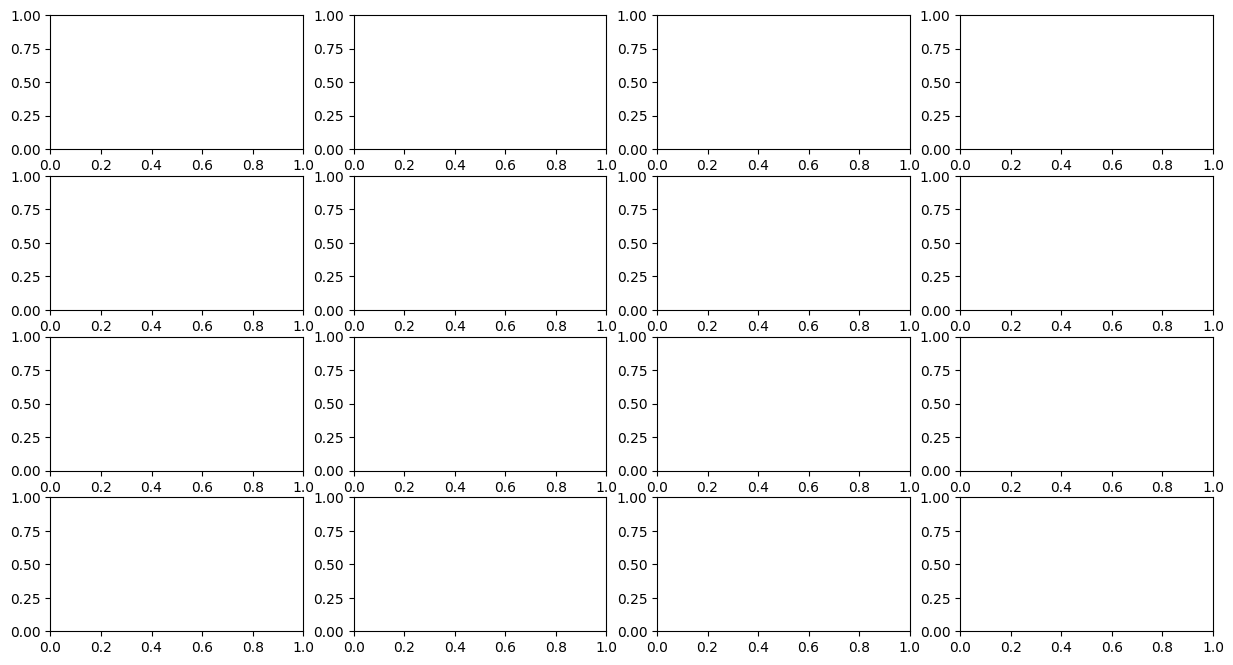

In [37]:
# A utility function to decode the output of the network

def decode_batch_prediction(pred):
  input_len = np.ones(pred.shape[0])*pred.shape[1]

  # Use greedy search For complex tasks , you can use beam search.
  results = keras.backend.ctc_decode(pred, input_length=input_len, greedy = True )[0][0][:,:max_len]
  print(results)
  #Iterate over the results and get back the text.
  output_text = []
  for res in results:
    res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))

    res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
    output_text.append(res)
  return output_text


for batch in test_ds.take(1):
  batch_images = i=tf.io.read_file("./words/g06/g06-011j/g06-011j-06-06.png")

  _, ax = plt.subplots(4,4,figsize=(15,8))

  preds = prediction_model.predict(batch_images)
  pred_texts = decode_batch_prediction(preds)

  for i in range(16):
    img = batch_images[i]
    img = tf.image.flip_left_right(img)
    img = tf.transpose(img, perm=[1,0,2])
    img = (img*255.0).numpy().clip(0, 255).astype(np.uint8)
    img = img[:, :, 0]

    title = f"Prediction: {pred_texts[i]}"
    ax[i // 4, i%4].imshow(img, cmap="gray")
    ax[i // 4, i%4].set_title(title)
    ax[i // 4, i%4].axis("off")

plt.show()